In [9]:
import numpy as np
from torchvision import datasets, models, transforms
from torchvision.models import ResNet18_Weights
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import copy
import matplotlib.pyplot as plt
import torchvision
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import tqdm

In [10]:
torch.manual_seed(0)

class UTKFace(Dataset):
    def __init__(self, image_paths):
        self.transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(),
                                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        self.image_paths = image_paths
        self.images = []
        self.circle = []
        self.h_bar = []
        self.triangle = []
        self.v_bar = []

        for path in os.listdir(image_paths):
            filename = path.split("_")
            if len(filename) == 6:
                self.images.append(image_paths + path)
                self.circle.append(int(filename[0]))
                self.h_bar.append(int(filename[1]))
                self.triangle.append(int(filename[2]))
                self.v_bar.append(int(filename[3]))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img = Image.open(self.images[index])
        img = self.transform(img)

        circle = self.circle[index]
        h_bar = self.h_bar[index]
        triangle = self.triangle[index]
        v_bar = self.v_bar[index]

        sample = {'image': img, 'circle': circle, 'h_bar': h_bar, 'triangle': triangle, 'v_bar': v_bar}

        return sample

In [11]:
class HydraNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        for param in self.net.parameters():
            param.requires_grad = False

        self.n_features = self.net.fc.in_features
        self.net.fc = nn.Identity()

        # head for circle
        self.net.fc1 = nn.Sequential(nn.Linear(self.n_features, 2))

        # head for h_bar
        self.net.fc2 = nn.Sequential(nn.Linear(self.n_features, 2))

        # head for triangle
        self.net.fc3 = nn.Sequential(nn.Linear(self.n_features, 2))

        # head for v_bar
        self.net.fc4 = nn.Sequential(nn.Linear(self.n_features, 2))

    def forward(self, x):
        circle_head = self.net.fc1(self.net(x))
        h_bar_head = self.net.fc2(self.net(x))
        triangle_head = self.net.fc3(self.net(x))
        v_bar_head = self.net.fc4(self.net(x))
        return circle_head, h_bar_head, triangle_head, v_bar_head

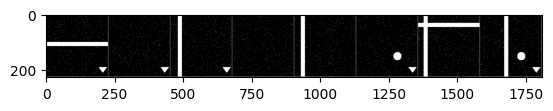

tensor([0, 0, 0, 0, 0, 1, 0, 1])
tensor([1, 0, 0, 0, 0, 0, 1, 0])
tensor([1, 1, 1, 0, 0, 1, 0, 1])
tensor([0, 0, 1, 0, 1, 0, 1, 1])


In [12]:
train_dataloader = DataLoader(UTKFace("./train_data/"), shuffle=True, batch_size=64)
val_dataloader = DataLoader(UTKFace("./val_data/"), shuffle=True, batch_size=64)

dataloaders = {'train': train_dataloader, 'val': val_dataloader}

dataset_sizes = {'train': len(train_dataloader.dataset), 'val': len(val_dataloader.dataset)}

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
image_and_labels = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(image_and_labels['image'][:8])

imshow(out)
print(image_and_labels['circle'][:8])
print(image_and_labels['h_bar'][:8])
print(image_and_labels['triangle'][:8])
print(image_and_labels['v_bar'][:8])

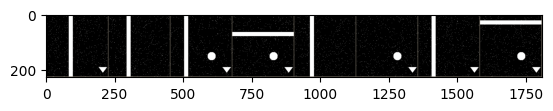

tensor([0, 0, 1, 1, 0, 1, 0, 1])
tensor([0, 0, 0, 1, 0, 0, 0, 1])
tensor([1, 0, 1, 1, 0, 1, 1, 1])
tensor([1, 1, 1, 0, 1, 0, 1, 0])


In [13]:
# Get a batch of validation data
image_and_labels = next(iter(val_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(image_and_labels['image'][:8])

imshow(out)
print(image_and_labels['circle'][:8])
print(image_and_labels['h_bar'][:8])
print(image_and_labels['triangle'][:8])
print(image_and_labels['v_bar'][:8])

In [14]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model = HydraNet().to(device=device)
# circle_loss = nn.CrossEntropyLoss()
# h_bar_loss = nn.CrossEntropyLoss()
# triangle_loss = nn.CrossEntropyLoss()
# v_bar_loss = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.09)

In [15]:
# n_epochs = 10

# for epoch in range(n_epochs):
#     print("Epoch: " + str(epoch))
#     model.train()
#     total_training_loss = 0
#     running_corrects_circle = 0
#     running_corrects_h_bar = 0
#     running_corrects_triangle = 0
#     running_corrects_v_bar = 0
    
#     for i, data in enumerate(train_dataloader):
#         inputs = data["image"].to(device=device)

#         circle_label = data["circle"].to(device=device)
#         h_bar_label = data["h_bar"].to(device=device)
#         triangle_label = data["triangle"].to(device=device)
#         v_bar_label = data["v_bar"].to(device=device)

#         optimizer.zero_grad()
#         circle_output, h_bar_output, triangle_output, v_bar_output = model(inputs)
        
#         _, circle_preds = torch.max(circle_output, 1)
#         _, h_bar_preds = torch.max(h_bar_output, 1)
#         _, triangle_preds = torch.max(triangle_output, 1)
#         _, v_bar_preds = torch.max(v_bar_output, 1)
        
        
#         loss_1 = circle_loss(circle_output, circle_label)
#         loss_2 = h_bar_loss(h_bar_output, h_bar_label)
#         loss_3 = triangle_loss(triangle_output, triangle_label)
#         loss_4 = v_bar_loss(v_bar_output, v_bar_label)

#         loss = loss_1 + loss_2 + loss_3 + loss_4
#         loss.backward()
#         optimizer.step()
        
        
#         total_training_loss += loss
#         running_corrects_circle += torch.sum(circle_preds == circle_label.data)
#         running_corrects_h_bar += torch.sum(h_bar_preds == h_bar_label.data)
#         running_corrects_triangle += torch.sum(triangle_preds == triangle_label.data)
#         running_corrects_v_bar += torch.sum(v_bar_preds == v_bar_label.data)
        
#     epoch_acc_circle = running_corrects_circle.double() / 2000
#     epoch_acc_h_bar = running_corrects_h_bar.double() / 2000
#     epoch_acc_triangle = running_corrects_triangle.double() / 2000
#     epoch_acc_v_bar = running_corrects_v_bar.double() / 2000
    
#     print('Circle Acc: {:.4f}'.format(epoch_acc_circle))
#     print('H-Bar Acc: {:.4f}'.format(epoch_acc_h_bar))
#     print('Triangle Acc: {:.4f}'.format(epoch_acc_triangle))
#     print('V-Bar Acc: {:.4f}'.format(epoch_acc_v_bar))

In [17]:
def train_model(model, criterion_dict, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_avg_acc = 0.0
    circle_loss = criterion_dict['circle_loss']
    h_bar_loss = criterion_dict['h_bar_loss']
    triangle_loss = criterion_dict['triangle_loss']
    v_bar_loss = criterion_dict['v_bar_loss']
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects_circle = 0
            running_corrects_h_bar = 0
            running_corrects_triangle = 0
            running_corrects_v_bar = 0
            
            # Iterate over data.
            for i, data in enumerate(dataloaders[phase]):
                inputs = data["image"].to(device=device)
                circle_label = data["circle"].to(device=device)
                h_bar_label = data["h_bar"].to(device=device)
                triangle_label = data["triangle"].to(device=device)
                v_bar_label = data["v_bar"].to(device=device)
        
                # zero the parameter gradients
                optimizer.zero_grad()

                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    circle_output, h_bar_output, triangle_output, v_bar_output = model(inputs)
                    _, circle_preds = torch.max(circle_output, 1)
                    _, h_bar_preds = torch.max(h_bar_output, 1)
                    _, triangle_preds = torch.max(triangle_output, 1)
                    _, v_bar_preds = torch.max(v_bar_output, 1)
        
        
                    loss_1 = circle_loss(circle_output, circle_label)
                    loss_2 = h_bar_loss(h_bar_output, h_bar_label)
                    loss_3 = triangle_loss(triangle_output, triangle_label)
                    loss_4 = v_bar_loss(v_bar_output, v_bar_label)

                    loss = loss_1 + loss_2 + loss_3 + loss_4

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects_circle += torch.sum(circle_preds == circle_label.data)
                running_corrects_h_bar += torch.sum(h_bar_preds == h_bar_label.data)
                running_corrects_triangle += torch.sum(triangle_preds == triangle_label.data)
                running_corrects_v_bar += torch.sum(v_bar_preds == v_bar_label.data)
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc_circle = running_corrects_circle.double() / dataset_sizes[phase]
            epoch_acc_h_bar = running_corrects_h_bar.double() / dataset_sizes[phase]
            epoch_acc_triangle = running_corrects_triangle.double() / dataset_sizes[phase]
            epoch_acc_v_bar = running_corrects_v_bar.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f}'.format(phase, epoch_loss))
            print(' Circle Acc: {:.4f}'.format(epoch_acc_circle))
            print(' H-Bar Acc: {:.4f}'.format(epoch_acc_h_bar))
            print(' Triangle Acc: {:.4f}'.format(epoch_acc_triangle))
            print(' V-Bar Acc: {:.4f}'.format(epoch_acc_v_bar))
            epoch_avg_acc = (epoch_acc_circle + epoch_acc_h_bar + epoch_acc_triangle + epoch_acc_v_bar)/4.
            print(' Average Accuracy: {:.4f}'.format(epoch_avg_acc))
            print('-'*10)
            
            # deep copy the model
            if phase == 'val' and epoch_avg_acc > best_avg_acc:
                best_avg_acc = epoch_avg_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    print('Best val Acc: {:4f}'.format(best_avg_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = HydraNet().to(device=device)
circle_loss = nn.CrossEntropyLoss()
h_bar_loss = nn.CrossEntropyLoss()
triangle_loss = nn.CrossEntropyLoss()
v_bar_loss = nn.CrossEntropyLoss()
criterion_dict = {'circle_loss': circle_loss, 'h_bar_loss': h_bar_loss, 'triangle_loss': triangle_loss,
                 'v_bar_loss': v_bar_loss}

optimizer_ft = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.09)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [19]:
model_ft = train_model(model, criterion_dict, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 2.6793
 Circle Acc: 0.4530
 H-Bar Acc: 0.6835
 Triangle Acc: 0.4910
 V-Bar Acc: 0.7225
 Average Accuracy: 0.5875
----------
val Loss: 2.3919
 Circle Acc: 0.6020
 H-Bar Acc: 0.7660
 Triangle Acc: 0.5780
 V-Bar Acc: 0.8500
 Average Accuracy: 0.6990
----------

Epoch 1/24
----------
train Loss: 2.2458
 Circle Acc: 0.7265
 H-Bar Acc: 0.8565
 Triangle Acc: 0.5845
 V-Bar Acc: 0.8720
 Average Accuracy: 0.7599
----------
val Loss: 2.0512
 Circle Acc: 0.8180
 H-Bar Acc: 0.8760
 Triangle Acc: 0.6740
 V-Bar Acc: 0.9180
 Average Accuracy: 0.8215
----------

Epoch 2/24
----------
train Loss: 1.9381
 Circle Acc: 0.8815
 H-Bar Acc: 0.9220
 Triangle Acc: 0.6580
 V-Bar Acc: 0.9355
 Average Accuracy: 0.8493
----------
val Loss: 1.7680
 Circle Acc: 0.9400
 H-Bar Acc: 0.9360
 Triangle Acc: 0.7120
 V-Bar Acc: 0.9560
 Average Accuracy: 0.8860
----------

Epoch 3/24
----------
train Loss: 1.7093
 Circle Acc: 0.9365
 H-Bar Acc: 0.9450
 Triangle Acc: 0.7275
 V-Bar Acc: 0.9610


In [21]:
torch.save(model.state_dict(), "HydraNet.pth")